__Papermils parameters__

In [1]:
FILL = 8146

---
---

# Lumi decrease

In [2]:
INTERACTIVE = True
FIGWIDTH    = 12

# CHOOSE INTERACTIVE ON/OFF
if INTERACTIVE:
    %matplotlib widget
else:
    %matplotlib inline
#----------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
import pandas as pd
import glob
import sys
sys.path.append('../')

# Make sure this import is after pandas
import Backend.ABPPandas

import Backend.Constants as cst
import Backend.NXCALS as nx


# Matplotlib config
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"


# Creating NXCALS variable containers
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]

buckets   = np.arange(3564)

# Locating data
DATA_PATH = '/eos/project/l/lhc-lumimod/LuminosityFollowUp/2022_test_v0.2.2/'
BMODE     = None#'STABLE'

# Importing fill data
database = pd.read_parquet(DATA_PATH+f'HX:FILLN={FILL}')
database = database.sort_index()
database.index.name = 'unix'
database.insert(0,'Timestamp',database.index)
database.insert(1,'Time',1e-9*(database.index - database.index[0]))
database['Timestamp'] = database['Timestamp'].apply(lambda t: pd.Timestamp(t).tz_localize('UTC'))



## Filling

Text(0.5, 0, 'Bunch number')

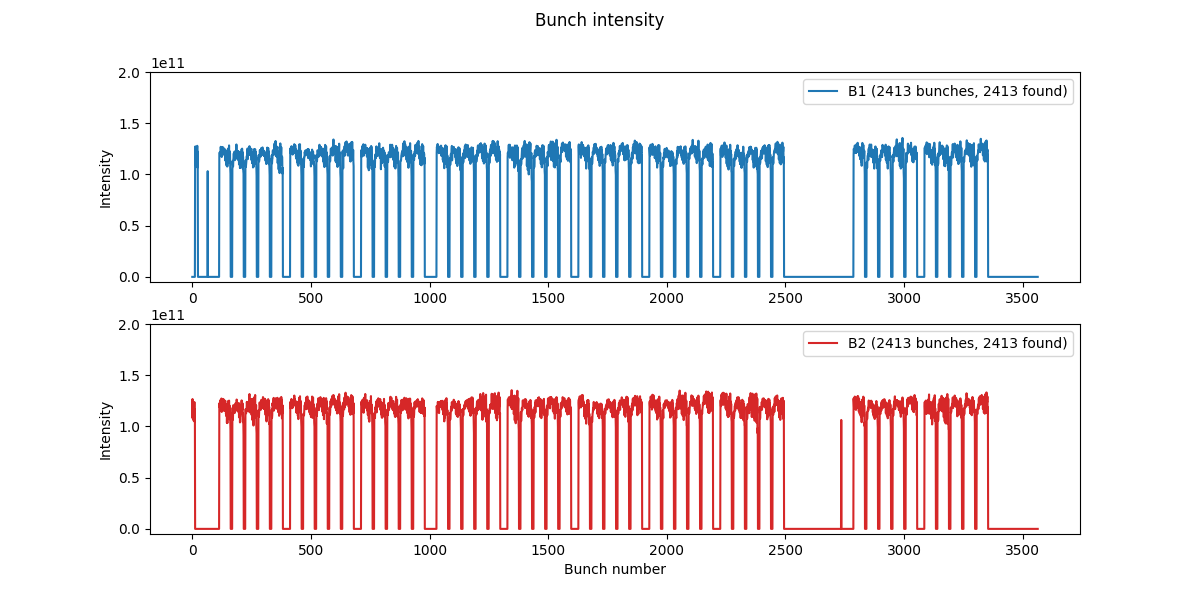

In [3]:
fig, axes = plt.subplots(figsize= (FIGWIDTH,6),ncols=1, nrows=2,gridspec_kw={'height_ratios': [1, 1]})

for beam,ax,color in zip(beams,axes,['C0','C3']):
    
    filled_ts = np.min(database[database[beam['Intensity']]== np.max(database[beam['Intensity']])].index)
    
    sub = database.dropna(subset=[beam['Nb']])
    _ts = sub.index[sub.index.get_loc(filled_ts, method='nearest')]
    Nb        = int(database.loc[_ts,beam['Nb']])

    sub = database.dropna(subset=[beam['bb_Intensity']])
    _ts = sub.index[sub.index.get_loc(filled_ts, method='nearest')]
    bunch_I   = database.loc[_ts,beam['bb_Intensity']]
    
    Nb_found = np.sum(bunch_I>0.5e11)

    plt.sca(ax)
    plt.plot(bunch_I,color=color,label = f'{beam.name} ({Nb} bunches, {Nb_found} found)')
    plt.legend()
    plt.ylim([-0.05e11,2e11])
    plt.ylabel('Intensity')
fig.suptitle('Bunch intensity')
plt.xlabel('Bunch number')


# ROI (Luminosity on)

2022-08-20 09:40:29.026530+00:00 | 2022-08-20 20:39:49.093901+00:00


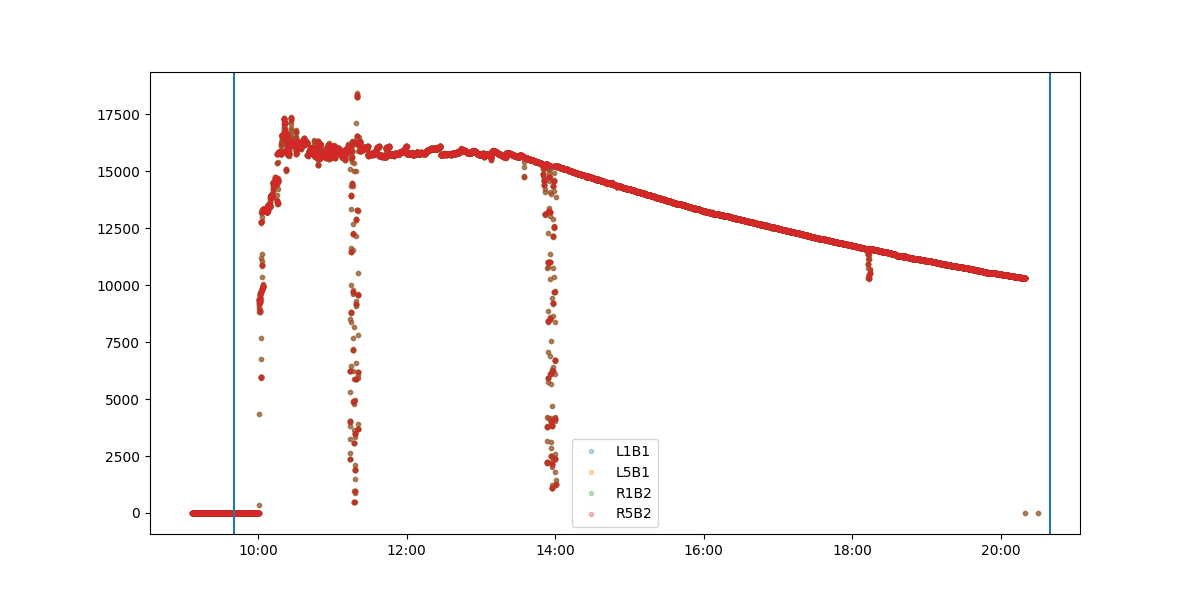

In [4]:
df = database.dropna(subset=[beams[0]['Luminosity']['ATLAS']])

start_ts = df[df[beams[0]['Luminosity']['ATLAS']]>1000]['Timestamp'].min()
stop_ts  = df[df[beams[0]['Luminosity']['ATLAS']]>1000]['Timestamp'].max()

start_ts,stop_ts = start_ts-pd.Timedelta(minutes=20),stop_ts+pd.Timedelta(minutes=20)
print(start_ts,'|',stop_ts)

plt.figure(figsize=(FIGWIDTH,6))
for wire in wires['B1']+wires['B2']:
    database.nxPlot('Timestamp',beams[0]['Luminosity']['ATLAS'],'.',alpha=0.3,label=wire.loc)
plt.axvline(start_ts)
plt.axvline(stop_ts)
plt.legend()

# Noise Lumi?


In [6]:
from scipy.interpolate import interp1d

# COMPUTING LHCB BB-LUMI:
injection_scheme = database['LHC.STATS:LHC:INJECTION_SCHEME'].iloc[0]
nb_coll = {'ATLAS':int(injection_scheme.split('_')[2]),'CMS':int(injection_scheme.split('_')[2]),'LHCB':int(injection_scheme.split('_')[4]),'ALICE':int(injection_scheme.split('_')[3])}

nb_coll = {'ATLAS':len(buckets),'CMS':len(buckets),'LHCB':len(buckets),'ALICE':len(buckets)}

try:
    for loc in ['ALICE','LHCB']:    
        database.insert(5,f'{loc}:BUNCH_LUMI_INST',database[beams[0]['bb_Luminosity']['ATLAS']])

        times         = database[beams[0]['bb_Luminosity']['ATLAS']].dropna().index
        interp_values = np.interp(times, database[f'{loc}:LUMI_TOT_INST'].dropna().index ,database[f'{loc}:LUMI_TOT_INST'].dropna()/nb_coll[loc])
        database.loc[times,f'{loc}:BUNCH_LUMI_INST'] = database[beams[0]['bb_Luminosity']['ATLAS']].dropna()*0 + interp_values
except:
    pass

# COMPUTING LUMI TOT
#============================
try:
    database.insert(4,'bb_LUMI_TOT',database[beams[0]['bb_Luminosity']['ATLAS']])
except:
    database['bb_LUMI_TOT'] = database[beams[0]['bb_Luminosity']['ATLAS']].copy()


times,lumi_tot  = database['bb_LUMI_TOT'].to_2D()
for loc in ['ALICE','CMS','LHCB']:
    times_found,allBunches = database[beams[0]['bb_Luminosity'][loc]].to_2D()

    lumi_tot   += interp1d(times_found,allBunches,axis=0)(times)

database.loc[times,'bb_LUMI_TOT'] = pd.DataFrame({'tmp':list(lumi_tot)},index=times)['tmp']

#============================


beam = beams[0]

for loc in ['ALICE','ALICE','CMS','LHCB']:

plt.figure(figsize=(FIGWIDTH,6))
plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')

times,datagrid = database.set_index('Timestamp')['bb_LUMI_TOT'].to_2D()

plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T,vmin=5, vmax=15,cmap='magma')
plt.axvline(wire_start,color='lime')
plt.axvline(wire_stop,color='lime')

cbar = plt.colorbar()
cbar.set_label('Luminosity')
plt.ylabel('Bunch Buckets')
plt.xlim([start_ts,stop_ts])




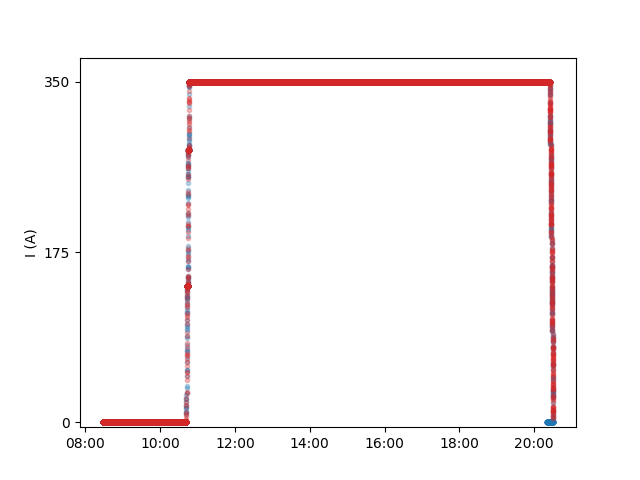

In [5]:
plt.figure()
for _IP in ['IP1','IP5']:
    for wire,color in zip(wires['B1']+wires['B2'],['C0','C0','C3','C3']):
        if wire.loc[1] == _IP[-1]:
            database.nxPlot('Timestamp',wire['I'],'.',alpha=0.3,color=color,label=wire.loc)
    plt.ylim([-5,375])
    plt.yticks([0,175,350])
    plt.ylabel('I (A)')

In [13]:
[key for key in list(database.keys()) if 'int' in key.lower()]

['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY',
 'LHC.BCTDC.A6R4.B2:BEAM_INTENSITY',
 'LHC.BCTDC.B6R4.B1:BEAM_INTENSITY',
 'LHC.BCTDC.B6R4.B2:BEAM_INTENSITY',
 'LHC.BCTFR.A6R4.B1:BUNCH_INTENSITY',
 'LHC.BCTFR.A6R4.B2:BUNCH_INTENSITY',
 'LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY',
 'LHC.BCTFR.B6R4.B2:BUNCH_INTENSITY']

KeyError: ['LHC.BQBBQ.CONTINUOUS.B2:TUNE_H']

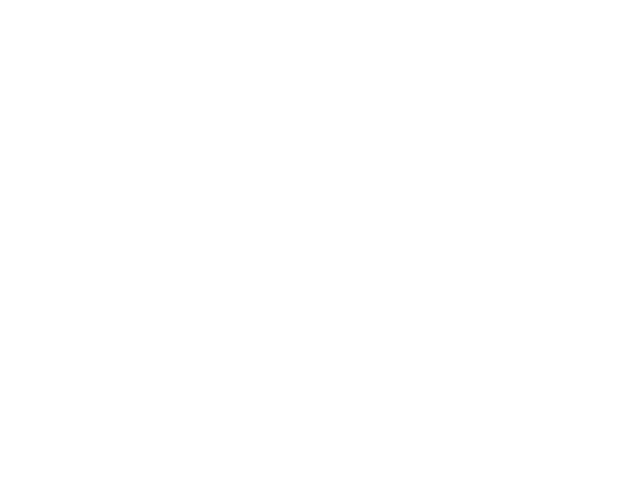

In [10]:
plt.figure()
database.nxPlot('Timestampt',beam['Qx'],'.')

# Intensity tot

In [9]:
_,tot_I = database.at_ts('2022-07-23 14:00',beam['Intensity'],return_ts=True)

In [7]:
_, bunch_I = database.at_ts('2022-07-23 14:00',beam['bb_Intensity'],return_ts=True)

In [10]:
np.sum(bunch_I)/tot_I

1.0166457736328907

In [17]:
np.abs(np.sum(bunch_I)-tot_I)/1e11

16.994976889958124

In [18]:
17/0.3

56.66666666666667

In [16]:
np.mean(bunch_I)/1e11

0.29123833856

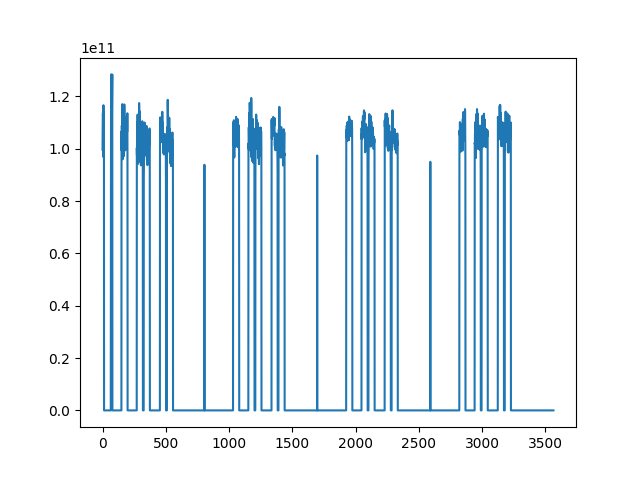

In [8]:
plt.figure()
plt.plot(bunch_I)

In [26]:
[key for key in database.keys() if 'intensity' in key.lower()]

['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY',
 'LHC.BCTDC.A6R4.B2:BEAM_INTENSITY',
 'LHC.BCTDC.B6R4.B1:BEAM_INTENSITY',
 'LHC.BCTDC.B6R4.B2:BEAM_INTENSITY',
 'LHC.BCTFR.A6R4.B1:BUNCH_INTENSITY',
 'LHC.BCTFR.A6R4.B2:BUNCH_INTENSITY',
 'LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY',
 'LHC.BCTFR.B6R4.B2:BUNCH_INTENSITY']

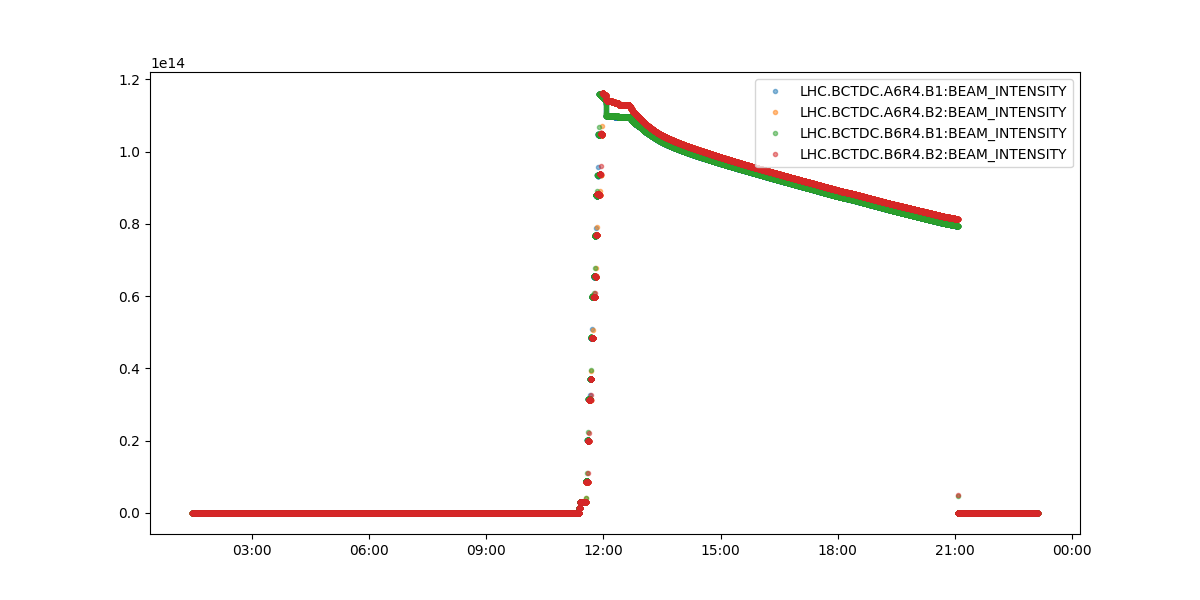

In [24]:

plt.figure(figsize=(12,6))
for key in [key for key in database.keys() if 'intensity' in key.lower()]:
    try:
        database.nxPlot('Timestamp',key,'.',alpha=0.5,label=key)
    except:
        pass
plt.legend()

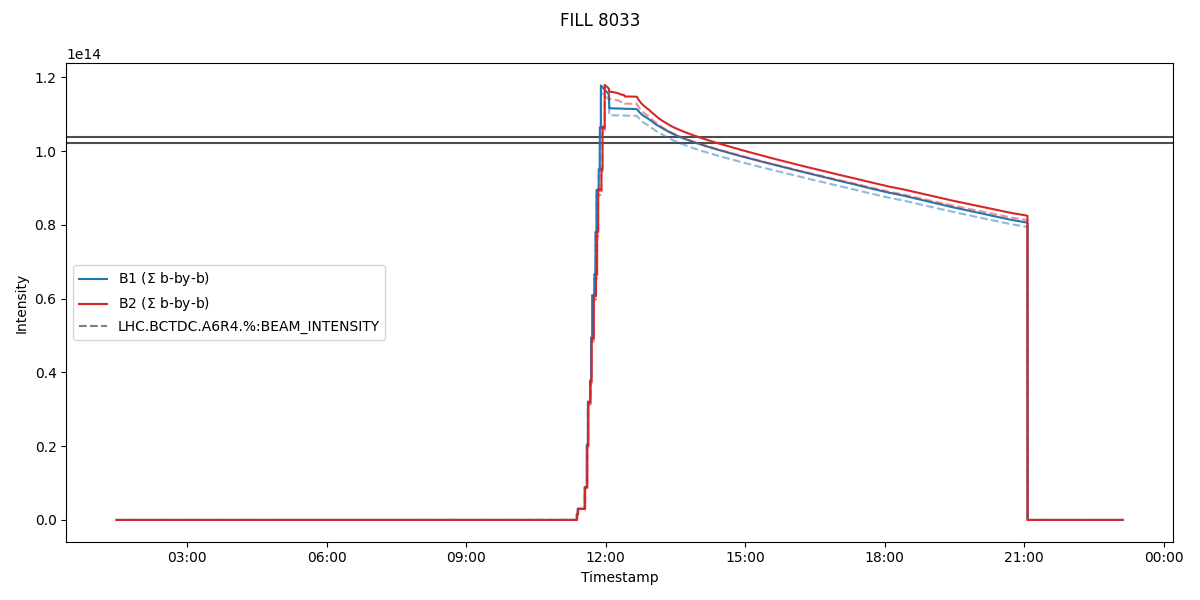

In [32]:
plt.figure(figsize=(12,6))
plt.axhline(np.sum(bunch_I),color='k',alpha=0.7)
plt.axhline(tot_I,color='k',alpha=0.7)
for beam,color in zip(beams,['C0','C3']):
    database.nxPlot('Timestamp',beam['Intensity'],'--',alpha=0.5,color=color)
    sub = database.dropna(subset=[beam['bb_Intensity']])
    plt.plot(sub['Timestamp'],sub[beam['bb_Intensity']].apply(lambda data:np.sum(data)),color=color,label=beam.name+r' ($\Sigma$ b-by-b)')
    
    
plt.plot([np.nan],[np.nan],'--',color='k',alpha=0.5,label='LHC.BCTDC.A6R4.%:BEAM_INTENSITY')
plt.legend()


plt.ylabel('Intensity')
plt.xlabel('Timestamp')
plt.suptitle(f'FILL {FILL}')

plt.tight_layout()

# Luminosity

In [33]:
top = np.sum(bunch_I)
bottom = tot_I

In [35]:
top/1e14,bottom/1e14

(1.03797347057664, 1.020978493686682)

In [35]:
%%timeit
test1 = np.stack(database[beams[0]['bb_Luminosity']['ATLAS']].dropna().to_numpy())[:,1]

27.9 ms ± 55.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
%%timeit
test2 = database[beams[0]['bb_Luminosity']['ATLAS']].dropna().apply(lambda data:data[1])



26.2 ms ± 65 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Test colormesh

In [15]:
from  scipy.interpolate import interp1d

Int64Index([1658539759171056000, 1658539819215521000, 1658539879368822000,
            1658539939519456000, 1658539999596415000, 1658540059657004000,
            1658540119931622000, 1658540179988271000, 1658540240232451000,
            1658540300325578000,
            ...
            1658609914471274000, 1658609974685262000, 1658610034998557000,
            1658610095027184000, 1658610155167487000, 1658610215297831000,
            1658610260876626000, 1658610320982078000, 1658610381280820000,
            1658610441386410000],
           dtype='int64', name='unix', length=1326)

In [39]:
%%timeit
times    = database['bb_LUMI_TOT'].dropna().index
lumi_tot = np.stack(database['bb_LUMI_TOT'].dropna().values)
for loc in ['ALICE']:
    sub = database[beams[0]['bb_Luminosity'][loc]].dropna()
    allBunches  = np.stack(sub.values)
    
    np.shape(interp1d(sub.index,allBunches,axis=0)(times))#
    #np.shape(np.array([np.interp(times,   sub.index, allBunches[:,bucket]) for bucket in buckets]).T)


106 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
np.stack(aux.values)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [32]:

times    = database['bb_LUMI_TOT'].dropna().index
lumi_tot = np.stack(database['bb_LUMI_TOT'].dropna().to_numpy())
for loc in ['ALICE']:
    aux = database[beams[0]['bb_Luminosity'][loc]].dropna().copy().sort_index()
    my_fun = interp1d(aux.index.values, list(aux.values), axis=0)
    my_filter=(database.index>=aux.index[0]) & (database.index<=aux.index[-1])

    database.loc[my_filter].index.map(my_fun) 


KeyboardInterrupt: 

In [28]:
%%timeit
np.shape(interp1d(times_found,allBunches,axis=0)(times))

294 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%%timeit
np.shape(np.array([np.interp(times,   times_found, allBunches[:,bucket]) for bucket in buckets]).T)

458 ms ± 6.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
np.stack(database['bb_LUMI_TOT'].values)

ValueError: all input arrays must have the same shape

In [40]:
np.stack(database['bb_LUMI_TOT'].dropna().values)

array([[3.6743168e-05, 3.4316712e-05, 4.0556177e-05, ..., 4.3675915e-05,
        3.5703255e-05, 3.6049893e-05],
       [3.1563817e-05, 3.7113550e-05, 3.5032397e-05, ..., 4.4744458e-05,
        3.7113550e-05, 3.6766691e-05],
       [4.1601623e-05, 3.6401372e-05, 4.1601623e-05, ..., 3.3627908e-05,
        3.7441419e-05, 3.4321274e-05],
       ...,
       [4.9041399e-05, 5.3185799e-05, 4.8350666e-05, ..., 4.9041399e-05,
        4.4897010e-05, 4.8696034e-05],
       [4.4376011e-05, 4.3335938e-05, 4.1602481e-05, ..., 3.6055433e-05,
        4.7496236e-05, 4.2642554e-05],
       [3.7789610e-05, 4.5070261e-05, 4.0563187e-05, ..., 5.0270741e-05,
        4.5070261e-05, 4.7150450e-05]], dtype=float32)

In [47]:
from pandas.core.base import PandasObject
# Manipulate Bunch-by-bunch
#=================================================

# Call: database[var].to_2D()
def to_2D(self,):
    sub = self.dropna()
    return sub.index,np.stack(sub.values)


PandasObject.to_2D  = to_2D
#=================================================

In [46]:
np.shape(allBunches

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [49]:
times

Int64Index([1658539759171056000, 1658539819215521000, 1658539879368822000,
            1658539939519456000, 1658539999596415000, 1658540059657004000,
            1658540119931622000, 1658540179988271000, 1658540240232451000,
            1658540300325578000,
            ...
            1658609914471274000, 1658609974685262000, 1658610034998557000,
            1658610095027184000, 1658610155167487000, 1658610215297831000,
            1658610260876626000, 1658610320982078000, 1658610381280820000,
            1658610441386410000],
           dtype='int64', name='unix', length=1326)

In [51]:
pd.DataFrame({'test':lumi_tot},index=times)

ValueError: Data must be 1-dimensional

In [57]:
(np.array(pd.Series(list(lumi_tot)).values.tolist()))

array([[3.6743168e-05, 3.4316712e-05, 4.0556177e-05, ..., 4.3675915e-05,
        3.5703255e-05, 3.6049893e-05],
       [3.1563817e-05, 3.7113550e-05, 3.5032397e-05, ..., 4.4744458e-05,
        3.7113550e-05, 3.6766691e-05],
       [4.1601623e-05, 3.6401372e-05, 4.1601623e-05, ..., 3.3627908e-05,
        3.7441419e-05, 3.4321274e-05],
       ...,
       [4.9041399e-05, 5.3185799e-05, 4.8350666e-05, ..., 4.9041399e-05,
        4.4897010e-05, 4.8696034e-05],
       [4.4376011e-05, 4.3335938e-05, 4.1602481e-05, ..., 3.6055433e-05,
        4.7496236e-05, 4.2642554e-05],
       [3.7789610e-05, 4.5070261e-05, 4.0563187e-05, ..., 5.0270741e-05,
        4.5070261e-05, 4.7150450e-05]], dtype=float32)

In [72]:
pd.DataFrame({'tmp':list(lumi_tot)},index=times)['tmp']

unix
1658539759171056000    [3.6743168e-05, 3.4316712e-05, 4.0556177e-05, ...
1658539819215521000    [3.1563817e-05, 3.711355e-05, 3.5032397e-05, 3...
1658539879368822000    [4.1601623e-05, 3.6401372e-05, 4.1601623e-05, ...
1658539939519456000    [3.3650387e-05, 3.4344215e-05, 4.2670177e-05, ...
1658539999596415000    [3.364024e-05, 4.1616873e-05, 3.502748e-05, 3....
                                             ...                        
1658610215297831000    [3.9876025, 4.415664, 4.829475, 5.388233, 4.21...
1658610260876626000    [3.3740838, 3.6494985, 3.890418, 4.1696844, 3....
1658610320982078000    [4.90414e-05, 5.31858e-05, 4.8350666e-05, 4.93...
1658610381280820000    [4.437601e-05, 4.333594e-05, 4.160248e-05, 4.1...
1658610441386410000    [3.778961e-05, 4.507026e-05, 4.0563187e-05, 4....
Name: tmp, Length: 1326, dtype: object

In [75]:
database.loc[times,'bb_LUMI_TOT'] = pd.DataFrame({'tmp':list(lumi_tot)},index=times)['tmp']

In [48]:
%%timeit
times,lumi_tot  = database['bb_LUMI_TOT'].to_2D()
for loc in ['ALICE']:
    times_found,allBunches = database[beams[0]['bb_Luminosity'][loc]].to_2D()

    
    lumi_tot   += interp1d(times_found,allBunches,axis=0)(times)

84.6 ms ± 201 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Text(0, 0.5, 'Bunch Buckets')

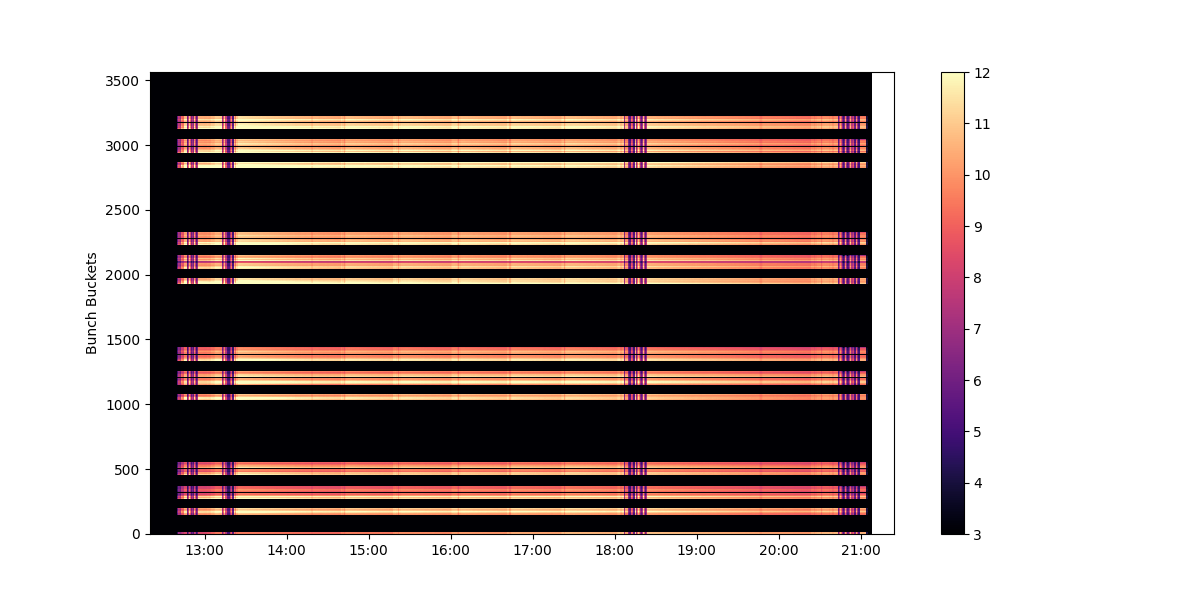

In [79]:
# COMPUTING LHCB BB-LUMI:
injection_scheme = database['LHC.STATS:LHC:INJECTION_SCHEME'].iloc[0]
nb_coll = {'ATLAS':int(injection_scheme.split('_')[2]),'CMS':int(injection_scheme.split('_')[2]),'LHCB':int(injection_scheme.split('_')[4]),'ALICE':int(injection_scheme.split('_')[3])}

nb_coll = {'ATLAS':len(buckets),'CMS':len(buckets),'LHCB':len(buckets),'ALICE':len(buckets)}

try:
    for loc in ['ALICE','LHCB']:    
        database.insert(5,f'{loc}:BUNCH_LUMI_INST',database[beams[0]['bb_Luminosity']['ATLAS']])

        times         = database[beams[0]['bb_Luminosity']['ATLAS']].dropna().index
        interp_values = np.interp(times, database[f'{loc}:LUMI_TOT_INST'].dropna().index ,database[f'{loc}:LUMI_TOT_INST'].dropna()/nb_coll[loc])
        database.loc[times,f'{loc}:BUNCH_LUMI_INST'] = database[beams[0]['bb_Luminosity']['ATLAS']].dropna()*0 + interp_values
except:
    pass

# COMPUTING LUMI TOT
#============================
try:
    database.insert(4,'bb_LUMI_TOT',database[beams[0]['bb_Luminosity']['ATLAS']])
except:
    database['bb_LUMI_TOT'] = database[beams[0]['bb_Luminosity']['ATLAS']].copy()


times,lumi_tot  = database['bb_LUMI_TOT'].to_2D()
for loc in ['ALICE','CMS','LHCB']:
    times_found,allBunches = database[beams[0]['bb_Luminosity'][loc]].to_2D()

    lumi_tot   += interp1d(times_found,allBunches,axis=0)(times)

database.loc[times,'bb_LUMI_TOT'] = pd.DataFrame({'tmp':list(lumi_tot)},index=times)['tmp']

#============================





times,datagrid = database.set_index('Timestamp')['bb_LUMI_TOT'].to_2D()

plt.figure(figsize=(FIGWIDTH,6))
plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T,vmin=3, vmax=12,cmap='magma')
plt.colorbar()
plt.xlim([start_ts,stop_ts])
plt.ylabel('Bunch Buckets')


Text(0, 0.5, 'Filled buckets')

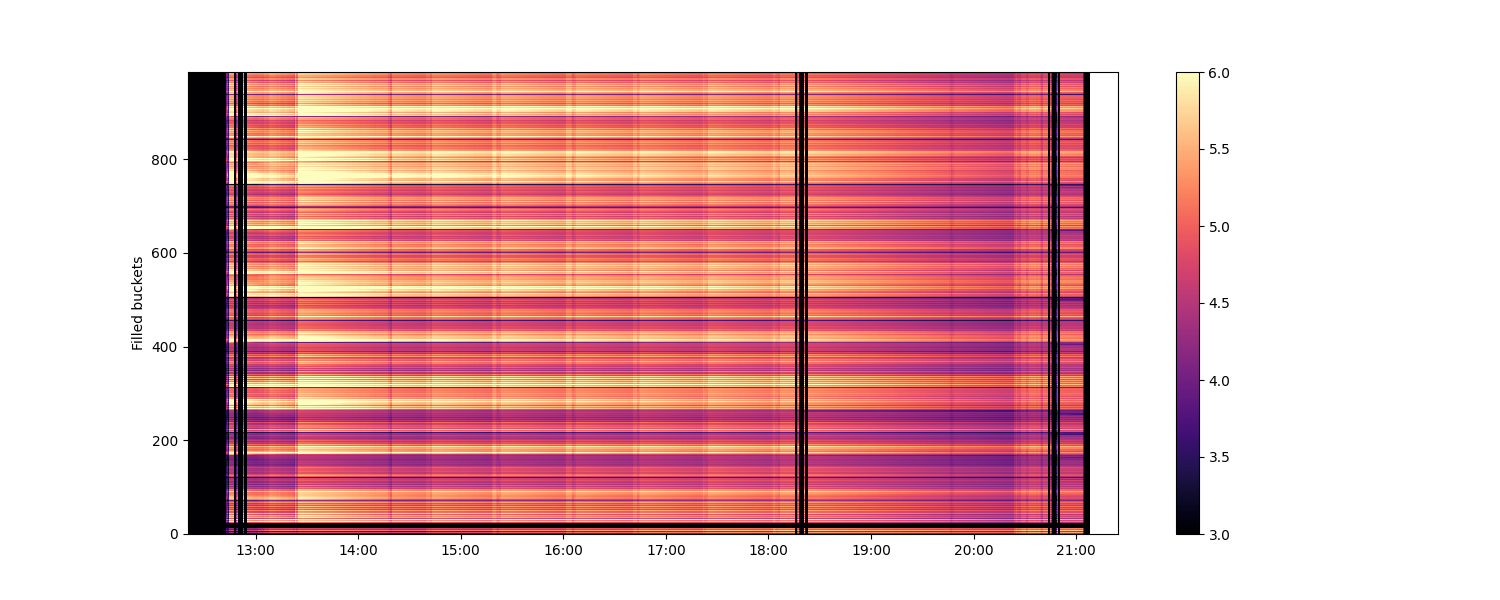

In [77]:
datagrid = np.stack(database[beams[0]['bb_Luminosity']['ATLAS']].dropna().to_numpy())
times    = database.set_index('Timestamp')[beams[0]['bb_Luminosity']['ATLAS']].dropna().index

datagrid = datagrid[:,np.arange(len(bunch_I))[bunch_I!=0]]

plt.figure(figsize=(FIGWIDTH,6))
plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T,vmin=3, vmax=6,cmap='magma')
plt.colorbar()
plt.xlim([start_ts,stop_ts])
plt.ylabel('Filled buckets')


In [47]:
np.shape(np.arange(-0.5, 10, 1)),np.shape(np.arange(4.5, 11, 1))aa

((11,), (7,))

In [44]:
np.shape(np.random.rand(6, 10))

(6, 10)

In [45]:
np.shape(datagrid)

(1326, 3564)

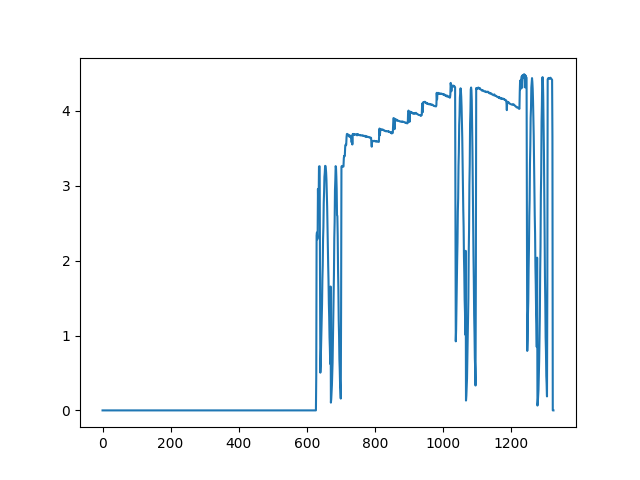

In [32]:
plt.figure()
plt.plot(test2.to_numpy())

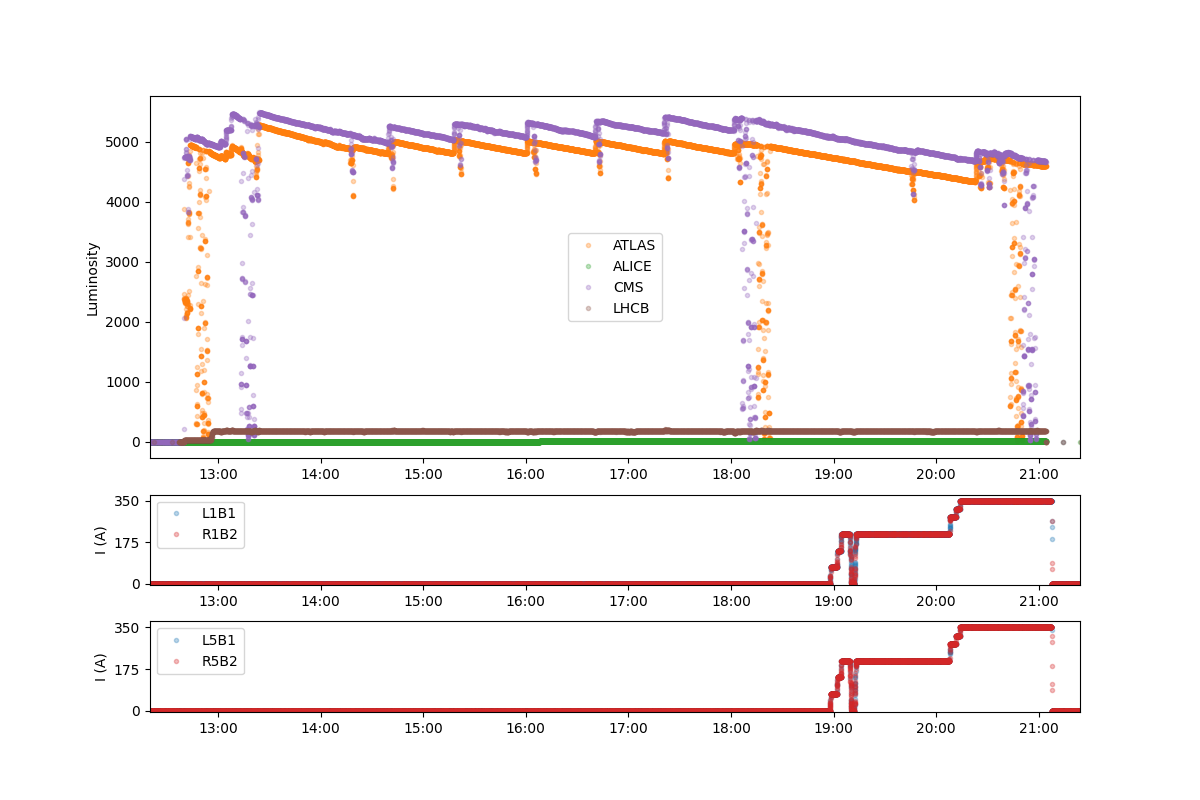

In [9]:




#------------------------------------------
def Make_Wire_Fig(figsize= (6,4)):
    fig, _axes = plt.subplots(figsize=figsize,ncols=1, nrows=3,gridspec_kw={'height_ratios': [4,1, 1]})

    axes = {'IP1':_axes[1],
			'IP5':_axes[2],
            'main':_axes[0]}

    # Taking away blue and red colors
    axes['main'].set_prop_cycle(color= ['#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
    
    return fig,axes
#------------------------------------------

# Fig Content
fig,axes = Make_Wire_Fig(figsize=(FIGWIDTH,8))

plt.sca(axes['main'])
for loc in ['ATLAS','ALICE','CMS','LHCB']:
    database.nxPlot('Timestamp',beams[0]['Luminosity'][loc],'.',alpha=0.3,label=loc)
plt.ylabel('Luminosity')


for _IP in ['IP1','IP5']:
    plt.sca(axes[_IP])
    for wire,color in zip(wires['B1']+wires['B2'],['C0','C0','C3','C3']):
        if wire.loc[1] == _IP[-1]:
            database.nxPlot('Timestamp',wire['I'],'.',alpha=0.3,color=color,label=wire.loc)
    plt.ylim([-5,375])
    plt.yticks([0,175,350])
    plt.ylabel('I (A)')

for ax in axes.values():
    plt.sca(ax)
    plt.legend()
    plt.xlim([start_ts,stop_ts])

# Lifetime vs Intensity

/home/phbelang/abp/WireDAQ/acc-py/base/2020.11/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/phbelang/abp/WireDAQ/acc-py/base/2020.11/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


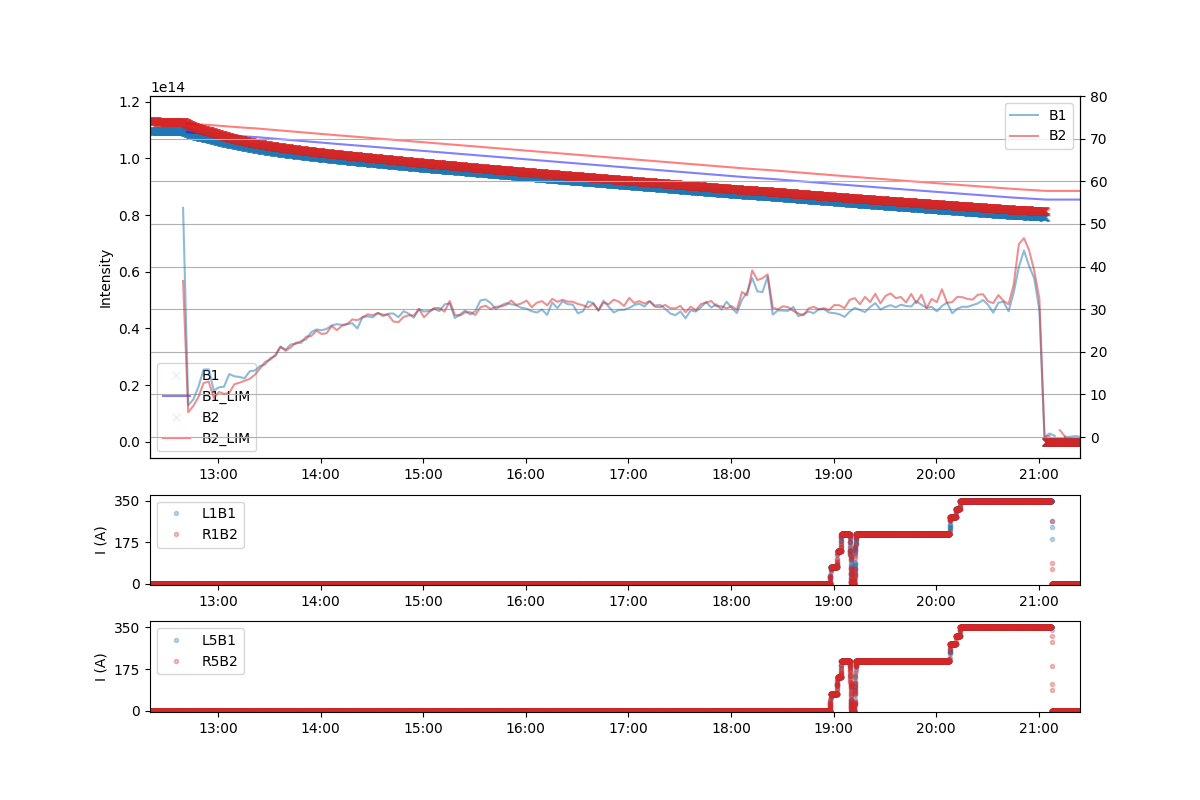

In [10]:
from scipy.optimize import curve_fit

def compute_lifetime(df,beam,window=5*60):
    
    
    # Fitting Intensity to the following:
    # N(t) = N0/(1+t/tau), tau-> lifetime

    # GROUPING DATA IN TIME WINDOWS
    sub = df.dropna(subset=[beam['Intensity']])
    grouped = sub.groupby(pd.cut(sub['Time'],bins=np.arange(sub.iloc[0]['Time'],sub.iloc[-1]['Time'],window)))
    
    # COMPUTING FIT FOR EACH WINDOW
    fit_df = grouped.apply(lambda data: curve_fit(lambda _t,tau :data.iloc[0][beam['Intensity']]/(1+(_t-data.iloc[0]['Time'])/tau), data['Time'], data[beam['Intensity']]))
    
    # UNPACKING RESULTS
    bin_time      = np.array(pd.Series(fit_df.index).apply(lambda line:line.mid))
    bin_unix      = (bin_time - sub.iloc[0]['Time'])*1e9 + sub.index[0]
    bin_timestamp = [pd.Timestamp(t).tz_localize('UTC') for t in bin_unix]
    bin_lifetime  = np.array(fit_df.apply(lambda line:line[0][0]))

    # DELETING UNPHYSICAL LIFETIMES
    bin_lifetime[bin_lifetime/3600>150] = np.nan

    return pd.DataFrame({'unix':bin_unix,'Timestamp':bin_timestamp,'Time':bin_time,'Lifetime':bin_lifetime})


# COMPUTING LUMI TOT
#============================
try:
    database.insert(4,'LUMI_TOT',database[beams[0]['Luminosity']['ATLAS']])
except:
    database['LUMI_TOT'] = database[beams[0]['Luminosity']['ATLAS']].copy()

for loc in ['ALICE','CMS','LHCB']:
    times = database[beams[0]['Luminosity']['ATLAS']].dropna().index
    database.loc[times,'LUMI_TOT'] += np.interp(times, database[beams[0]['Luminosity'][loc]].dropna().index,database[beams[0]['Luminosity'][loc]].dropna())
#============================

# COMPUTING INTENSITY LIMIT
#============================
try:
    for beam in beams:
        database.insert(4,f'INT_LIM_{beam.name}',np.nan)
except:
    for beam in beams:
        database[f'INT_LIM_{beam.name}'] = np.nan

# Adding upper bound of intensity
for beam in beams:
    sub   = database.dropna(subset=[beam['Intensity']])
    
    sig_c = 80e-3
    
    L     = np.interp(sub[beam['Intensity']].index, database['LUMI_TOT'].dropna().index,database['LUMI_TOT'].dropna())   
    dNdt  = -L*1e6*sig_c

    unix_stable = database[database['HX:BMODE'] == 'STABLE'].index[0]
    N0_loc = np.argmin(np.abs(sub.index -unix_stable))
    tVec   = (sub[beam['Intensity']].index[N0_loc:])*1e-9
    N      = sub.iloc[N0_loc][beam['Intensity']] + np.cumsum(dNdt[N0_loc:-1]*np.diff(tVec))
    database.loc[sub.index[N0_loc:-1],f'INT_LIM_{beam.name}'] = N
#============================

# Fig Content
fig,axes = Make_Wire_Fig(figsize=(FIGWIDTH,8))

plt.sca(axes['main'])
for beam,color,color2 in zip(beams,['C0','C3'],['b','r']):
    database.nxPlot('Timestamp',beam['Intensity'],'x',alpha=0.1,color=color,label=beam.name)

    database.nxPlot('Timestamp',f'INT_LIM_{beam.name}','-',alpha=0.5,color=color2,label=beam.name + '_LIM')
    


plt.ylabel('Intensity')

# Plotting lifetime
axRight = axes['main'].twinx()
for beam,color in zip(beams,['C0','C3']):
    result_df = compute_lifetime(database,beam,window=3*60)
    plt.plot(result_df['Timestamp'],result_df['Lifetime']/3600,'-',color=color,alpha=0.5,label=beam.name)
plt.ylim([-5,80])
plt.legend()
plt.grid(axis='y')


for _IP in ['IP1','IP5']:
    plt.sca(axes[_IP])
    for wire,color in zip(wires['B1']+wires['B2'],['C0','C0','C3','C3']):
        if wire.loc[1] == _IP[-1]:
            database.nxPlot('Timestamp',wire['I'],'.',alpha=0.3,color=color,label=wire.loc)
    plt.ylim([-5,375])
    plt.yticks([0,175,350])
    plt.ylabel('I (A)')

for ax in axes.values():
    plt.sca(ax)
    plt.legend()
    plt.xlim([start_ts,stop_ts])



# Lifetime vs Lumi Limit

/home/phbelang/abp/WireDAQ/acc-py/base/2020.11/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/phbelang/abp/WireDAQ/acc-py/base/2020.11/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


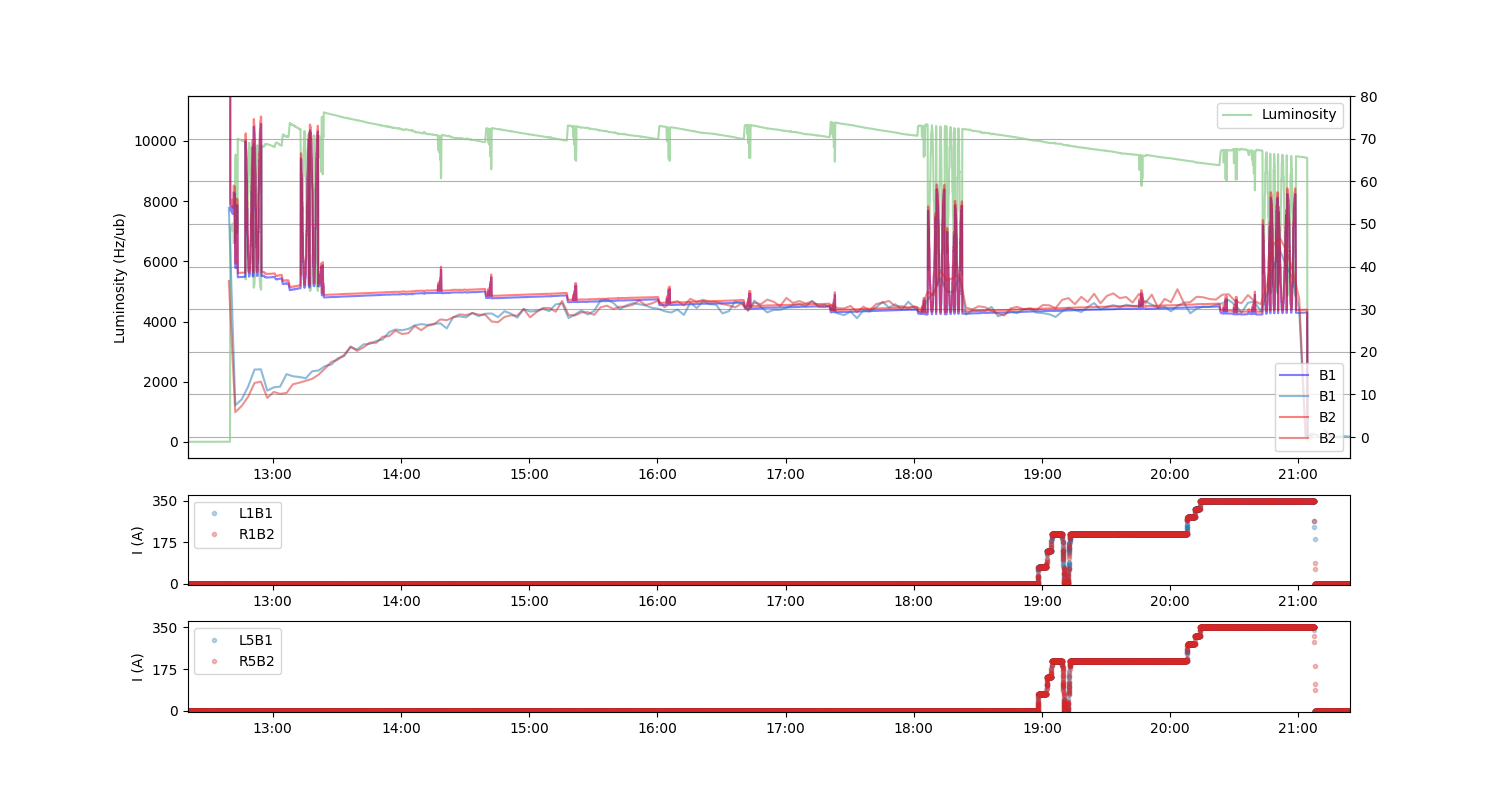

In [7]:


# Fig Content
fig,axes = Make_Wire_Fig(figsize=(15,8))
plt.sca(axes['main'])
database.nxPlot('Timestamp','LUMI_TOT',alpha=0.4,color='C2',label='Luminosity')
plt.ylabel('Luminosity (Hz/ub)')
#axes['main'].legend(loc='upper right')

axRight = axes['main'].twinx()
for beam,color,color2 in zip(beams,['C0','C3'],['b','r']):
    sig_c = 80e-3
    
    # Interpolating intensity
    times = database['LUMI_TOT'].dropna().index
    N     = np.interp(times, database[beam['Intensity']].dropna().index,database[beam['Intensity']].dropna())
    L     = database['LUMI_TOT'].dropna()
    tau   = N/(L*1e6*sig_c)

    timestamp = database.dropna(subset=['LUMI_TOT'])['Timestamp']

    plt.plot(timestamp,tau/3600,color=color2,alpha=0.5,label=beam.name)

    result_df = compute_lifetime(database,beam,window=3*60)
    plt.plot(result_df['Timestamp'],result_df['Lifetime']/3600,'-',color=color,alpha=0.5,label=beam.name)

plt.legend(loc='lower right')
plt.ylim([-5,80])
plt.grid(axis='y')




for _IP in ['IP1','IP5']:
    plt.sca(axes[_IP])
    for wire,color in zip(wires['B1']+wires['B2'],['C0','C0','C3','C3']):
        if wire.loc[1] == _IP[-1]:
            database.nxPlot('Timestamp',wire['I'],'.',alpha=0.3,color=color,label=wire.loc)
    plt.ylim([-5,375])
    plt.yticks([0,175,350])
    plt.ylabel('I (A)')

for ax in axes.values():
    plt.sca(ax)
    plt.legend()
    plt.xlim([start_ts,stop_ts])


# Cross section

/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/home/phbelang/abp/WireDAQ/acc-py/base/2020.11/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/home/phbelang/abp/WireDAQ/acc-py/base/2020.11/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=Optim

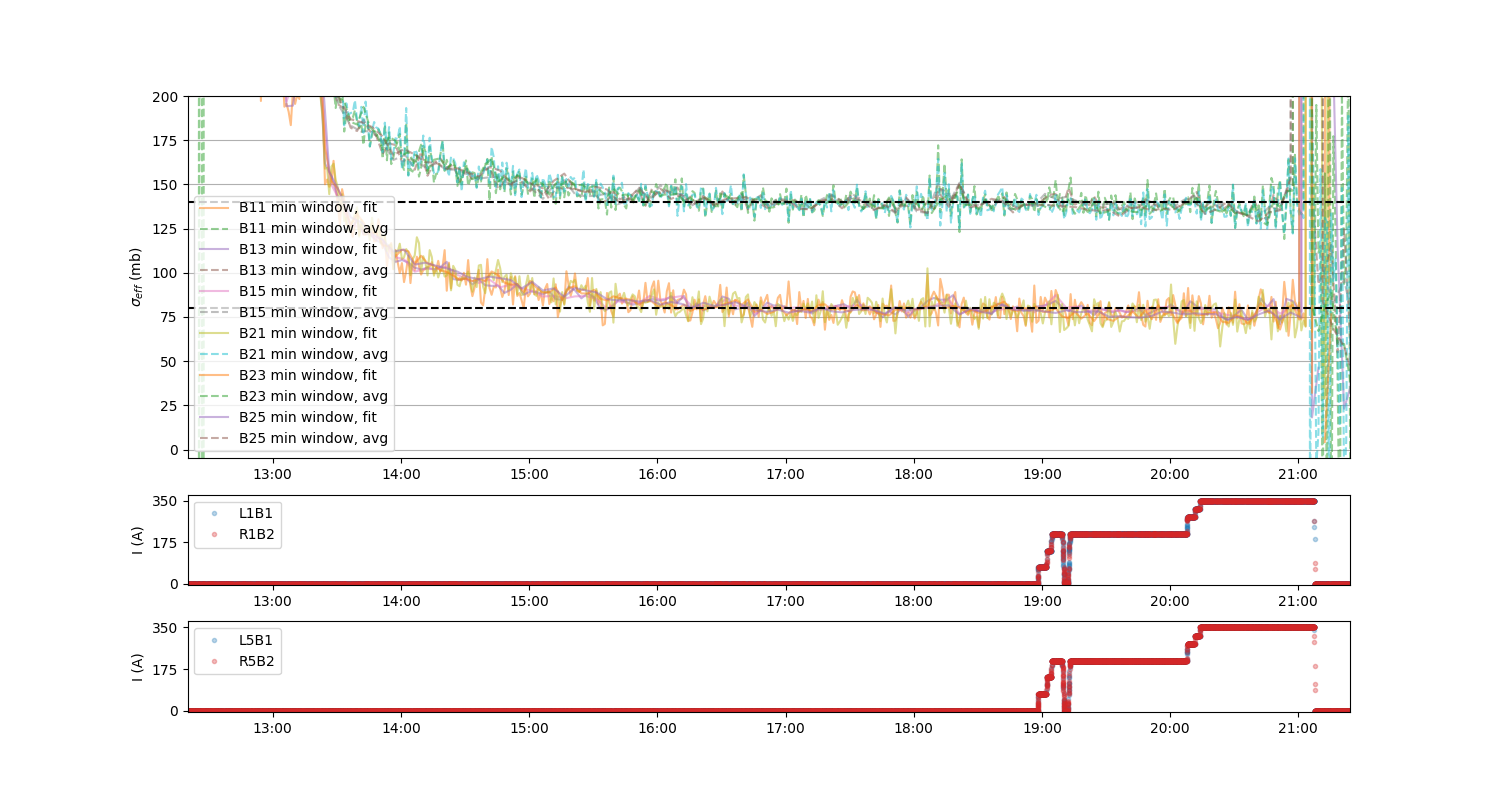

In [9]:
def compute_xsection_fit(df,beam,window=5*60):
    
    # Fitting Intensity to the following:
    # N(t) = N0/(1+t/tau), tau-> lifetime

    # GROUPING DATA IN TIME WINDOWS
    sub     = df.dropna(subset=[beam['Intensity']]).copy()
    grouped = sub.groupby(pd.cut(sub['Time'],bins=np.arange(sub.iloc[0]['Time'],sub.iloc[-1]['Time'],window)))
    sub.loc[:,'LUMI_TOT'] = np.interp(sub[beam['Intensity']].index, database['LUMI_TOT'].dropna().index,database['LUMI_TOT'].dropna())   

    # COMPUTING FIT FOR EACH WINDOW
    fit_df = grouped.apply(lambda data: curve_fit(lambda _t,tau :data.iloc[0][beam['Intensity']]/(1+(_t-data.iloc[0]['Time'])/tau), data['Time'], data[beam['Intensity']]))
    
    # UNPACKING RESULTS
    bin_time      = np.array(pd.Series(fit_df.index).apply(lambda line:line.mid))
    bin_unix      = (bin_time - sub.iloc[0]['Time'])*1e9 + sub.index[0]
    bin_timestamp = [pd.Timestamp(t).tz_localize('UTC') for t in bin_unix]
    bin_lifetime  = np.array(fit_df.apply(lambda line:line[0][0]))
    
    # DELETING UNPHYSICAL LIFETIMES
    bin_lifetime[bin_lifetime/3600>150] = np.nan

    # Computing cross section
    bin_xsection  = grouped.apply(lambda data: data.iloc[0][beam['Intensity']]/np.mean(1e6*data['LUMI_TOT']))/bin_lifetime


    return pd.DataFrame({'unix':bin_unix,'Timestamp':bin_timestamp,'Time':bin_time,'Lifetime':bin_lifetime,'sig_c':bin_xsection})


def compute_xsection_avg(df,beam,window=5*60):
    # GROUPING DATA IN TIME WINDOWS
    sub     = database.dropna(subset=[beam['Intensity']]).copy()
    grouped = sub.groupby(pd.cut(sub['Time'],bins=np.arange(sub.iloc[0]['Time'],sub.iloc[-1]['Time'],window)))
    sub.loc[:,'LUMI_TOT'] = np.interp(sub[beam['Intensity']].index, database['LUMI_TOT'].dropna().index,database['LUMI_TOT'].dropna())   

    # AVG in each time window
    bin_time  = np.array(pd.Series(grouped.groups.keys()).apply(lambda line:line.mid))
    dNdt      = np.diff(grouped[beam['Intensity']].mean())/np.diff(bin_time)
    L         = np.array(1e6*grouped['LUMI_TOT'].mean())[:-1]

    # Computing cross section
    bin_xsection  = -dNdt/L


    # UNPACKING RESULTS
    bin_unix      = (bin_time - sub.iloc[0]['Time'])*1e9 + sub.index[0]
    bin_timestamp = [pd.Timestamp(t).tz_localize('UTC') for t in bin_unix]
    

    return pd.DataFrame({'unix':bin_unix[:-1],'Timestamp':bin_timestamp[:-1],'Time':bin_time[:-1],'sig_c':bin_xsection})



# Fig Content
fig,axes = Make_Wire_Fig(figsize=(15,8))


plt.sca(axes['main'])
for beam,color,color2 in zip(beams,['C0','C3'],['b','r']):
    for wind in [1,3,5]:
        result_df = compute_xsection_fit(database,beam,window=wind*60)
        result_df2 = compute_xsection_avg(database,beam,window=wind*60)

        plt.plot(result_df['Timestamp'],result_df['sig_c']/1e-3,'-',alpha=0.5,label=beam.name+f'{wind} min window, fit')
        plt.plot(result_df2['Timestamp'],60+result_df2['sig_c']/1e-3,'--',alpha=0.5,label=beam.name+f'{wind} min window, avg')

plt.legend(loc='lower right')
plt.ylabel(r'$\sigma_{eff}$ (mb)')
plt.axhline(80,ls='--',color='k')
plt.axhline(140,ls='--',color='k')
plt.ylim([-5,200])
plt.grid(axis='y')




for _IP in ['IP1','IP5']:
    plt.sca(axes[_IP])
    for wire,color in zip(wires['B1']+wires['B2'],['C0','C0','C3','C3']):
        if wire.loc[1] == _IP[-1]:
            database.nxPlot('Timestamp',wire['I'],'.',alpha=0.3,color=color,label=wire.loc)
    plt.ylim([-5,375])
    plt.yticks([0,175,350])
    plt.ylabel('I (A)')

for ax in axes.values():
    plt.sca(ax)
    plt.legend()
    plt.xlim([start_ts,stop_ts])
    